In [1]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt

2024-03-27 11:34:28.932023: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-27 11:34:29.381518: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 11:34:30.023800: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow version: 2.16.1


In [2]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='uniform',
                                              trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='uniform',
                                           trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:, :, :4], axis=-1)
        time_linear = self.weights_linear * x + self.bias_linear  # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1)  # Add dimension (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1)  # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1)  # shape = (batch, seq_len, 2)

    def get_config(self):  # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config


In [3]:
class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = Dense(self.d_k,
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

        self.key = Dense(self.d_k,
                         input_shape=input_shape,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='glorot_uniform')

        self.value = Dense(self.d_v,
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

    def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x / np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)

        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out


In [4]:
class MultiAttention(Layer):
    def __init__(self, d_k, d_v, n_heads):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.attn_heads = list()

    def build(self, input_shape):
        for n in range(self.n_heads):
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

            # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7
        self.linear = Dense(input_shape[0][-1],
                            input_shape=input_shape,
                            kernel_initializer='glorot_uniform',
                            bias_initializer='glorot_uniform')

    def call(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = tf.concat(attn, axis=-1)
        multi_linear = self.linear(concat_attn)
        return multi_linear

In [5]:
class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout

    def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
        # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7
        self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer

    def get_config(self):  # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'d_k': self.d_k,
                       'd_v': self.d_v,
                       'n_heads': self.n_heads,
                       'ff_dim': self.ff_dim,
                       'attn_heads': self.attn_heads,
                       'dropout_rate': self.dropout_rate})
        return config


In [61]:
from datetime import datetime
tsmc_data = pd.read_csv('./tsmc_stock_prices_INT_close_only_datetime_2010-2023.csv')
tsmc_data.index = tsmc_data["date"]
tsmc_data = tsmc_data.drop(columns=["date"])
print(tsmc_data.head())

                     close
date                      
2010-01-04 00:00:00     64
2010-01-05 00:00:00     64
2010-01-06 00:00:00     64
2010-01-07 00:00:00     64
2010-01-08 00:00:00     64


In [62]:
#######################################################
from sklearn.preprocessing import MinMaxScaler
import numpy as np

input_length = 30
output_length = 1
dataset = tsmc_data['close'].to_numpy()

scaler = MinMaxScaler()
dataset_norm = scaler.fit_transform(dataset.reshape(-1, 1)).flatten()
dataset_list = []
for i in range(len(dataset) - input_length - output_length):
    dataset_list.append(dataset_norm[i:i + input_length + output_length])
dataset_list = np.array(dataset_list)

split_idx_train = int(len(dataset_list) * 0.8)
split_idx_val = int(len(dataset_list) * 0.9)

x_train = dataset_list[:split_idx_train, :-1]
y_train = dataset_list[:split_idx_train, -1:]

x_val = dataset_list[split_idx_train:split_idx_val, :-1]
y_val = dataset_list[split_idx_train:split_idx_val, -1:]

x_test = dataset_list[split_idx_val:, :-1]
y_test = dataset_list[split_idx_val:, -1:]

print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print('x_val.shape:', x_val.shape)
print('y_val.shape:', y_val.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)
#######################################################
# from sklearn.preprocessing import MinMaxScaler
# import numpy as np

# input_length = 30
# output_length = 1
# dataset = tsmc_data[['high', 'low', 'open', 'close']].to_numpy()

# scaler = MinMaxScaler()
# dataset_norm = scaler.fit_transform(dataset)
# dataset_list = []
# for i in range(len(dataset) - input_length - output_length):
#     dataset_list.append(dataset_norm[i:i + input_length + output_length])
# dataset_list = np.array(dataset_list)

# split_idx_train = int(len(dataset_list) * 0.8)
# split_idx_val = int(len(dataset_list) * 0.9)

# x_train = dataset_list[:split_idx_train, :-1, :]
# y_train = dataset_list[:split_idx_train, -1, -1]

# x_val = dataset_list[split_idx_train:split_idx_val, :-1, :]
# y_val = dataset_list[split_idx_train:split_idx_val, -1, -1]

# x_test = dataset_list[split_idx_val:, :-1, :]
# y_test = dataset_list[split_idx_val:, -1, -1]

# # y_train = np.expand_dims(y_train, axis=1)
# # y_val = np.expand_dims(y_val, axis=1)
# # y_test = np.expand_dims(y_test, axis=1)

# print('x_train.shape:', x_train.shape)
# print('y_train.shape:', y_train.shape)
# print('x_val.shape:', x_val.shape)
# print('y_val.shape:', y_val.shape)
# print('x_test.shape:', x_test.shape)
# print('y_test.shape:', y_test.shape)


x_train.shape: (2718, 30)
y_train.shape: (2718, 1)
x_val.shape: (340, 30)
y_val.shape: (340, 1)
x_test.shape: (340, 30)
y_test.shape: (340, 1)


In [63]:
batch_size = 256
seq_len = 30

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

In [79]:
time_embedding_c = Time2Vector(seq_len)
attn_layer1_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
attn_layer2_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
attn_layer3_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

in_seq_c = Input(shape=(seq_len, 1))
x_c = time_embedding_c(in_seq_c)
x_c = Concatenate(axis=-1)([in_seq_c, x_c])
x_c = attn_layer1_c((x_c, x_c, x_c))
x_c = attn_layer2_c((x_c, x_c, x_c))
x_c = attn_layer3_c((x_c, x_c, x_c))
x_c = GlobalAveragePooling1D(data_format='channels_first')(x_c)
x_c = Dropout(0.1)(x_c)
x_c = Dense(64, activation='relu')(x_c)
x_c = Dropout(0.1)(x_c)
out_c = Dense(1, activation='linear')(x_c)

model = Model(inputs=[in_seq_c], outputs=[out_c])

model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])

print(model.summary())

/home/henrycheng/python_workspace/notebookenv/lib/python3.11/site-packages/keras/src/layers/normalization/layer_normalization.py:122: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/henrycheng/python_workspace/notebookenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vector_14     │ (None, 30, 2)     │        120 │ input_layer_15[0… │
│ (Time2Vector)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 30, 3)     │          0 │ input_layer_15[0… │
│ (Concatenate)       │                   │            │ time2_vector_14[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 30, 3)     │     47,890 │ concatenate_14[0… │
│ (TransformerEncode… │                   │            │ concatenate_14[0… │
│                     │                   │            │ concatenate_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 30, 3)     │     47,890 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ transformer_enco… │
│                     │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 30, 3)     │     47,890 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ transformer_enco… │
│                     │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 30)        │          0 │ transformer_enco… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_126         │ (None, 30)        │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1806 (Dense)  │ (None, 64)        │      1,984 │ dropout_126[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_127         │ (None, 64)        │          0 │ dense_1806[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1807 (Dense)  │ (None, 1)         │         65 │ dropout_127[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 145,839 (569.68 KB)

 Trainable params: 145,839 (569.68 KB)

 Non-trainable params: 0 (0.00 B)

None


In [80]:
# history = model.fit([x_train],[y_train],
#                     batch_size=batch_size,
#                     epochs=35)

from keras.callbacks import EarlyStopping


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=200,
                    validation_data=(x_val, y_val),
                    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])


Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 487ms/step - loss: 0.0613 - mae: 0.1759 - mape: 101.2056 - val_loss: 0.5223 - val_mae: 0.7525 - val_mape: 90.2600
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - loss: 0.0350 - mae: 0.1216 - mape: 211.5628 - val_loss: 0.3228 - val_mae: 0.5967 - val_mape: 71.4064
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 278ms/step - loss: 0.0173 - mae: 0.0801 - mape: 261.4625 - val_loss: 0.1384 - val_mae: 0.3974 - val_mape: 47.2903
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - loss: 0.0072 - mae: 0.0572 - mape: 207.0153 - val_loss: 0.0440 - val_mae: 0.2279 - val_mape: 26.7775
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - loss: 0.0033 - mae: 0.0363 - mape: 78.1786 - val_loss: 0.0099 - val_mae: 0.1048 - val_mape: 12.2334
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - loss: 0.0016 - mae: 0.0279 - mape: 58.3861 - val_loss: 0.0072 - val_mae: 0.0581 - val_mape: 7.2297
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - loss: 0.001

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step


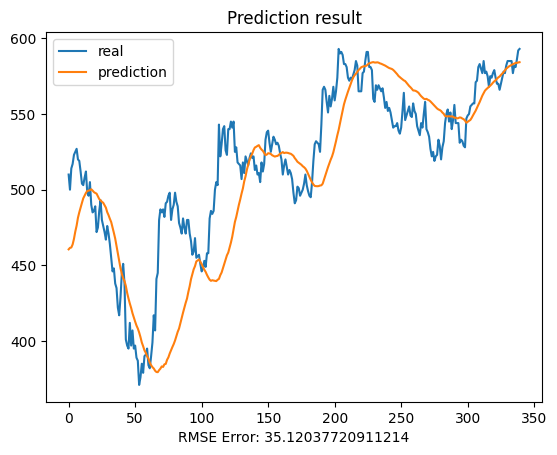

In [81]:
from sklearn.metrics import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
# y_real = scaler.inverse_transform(y_test.flatten().reshape(-1, 1)).flatten()

y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
# y_predict = scaler.inverse_transform(y_predict).reshape(-1, 1)  # 調整形狀為 (340, 1)
# print('real: ', y_real.shape)


plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
# plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
rmse = np.sqrt(mean_squared_error(y_real, y_predict))
plt.xlabel('RMSE Error: {}'.format(rmse))
plt.legend()
plt.title('Prediction result')
plt.show()

In [82]:
model.save_weights('./transformer_close_checkpoint.weights.h5')

In [15]:
history = model.fit([x_train],[y_train],
                    batch_size=batch_size,
                    epochs=200)

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 255ms/step - loss: 0.0013 - mae: 0.0257 - mape: 46.4616
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - loss: 0.0011 - mae: 0.0238 - mape: 42.1355
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - loss: 0.0012 - mae: 0.0251 - mape: 47.8446
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - loss: 0.0010 - mae: 0.0221 - mape: 49.6203
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - loss: 9.7662e-04 - mae: 0.0212 - mape: 41.4597
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - loss: 0.0011 - mae: 0.0225 - mape: 38.8264
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - loss: 0.0011 - mae: 0.0225 - mape: 38.9608
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - loss: 0.0013 - mae: 0.0243 - mape: 37.8210
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - loss: 0.0011 - mae: 0.0218 - mape: 48.5477
Epoch 10/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - loss: 0.0011 - mae: 0.0239 - mape: 43.6871
Epoch 11/200
1

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


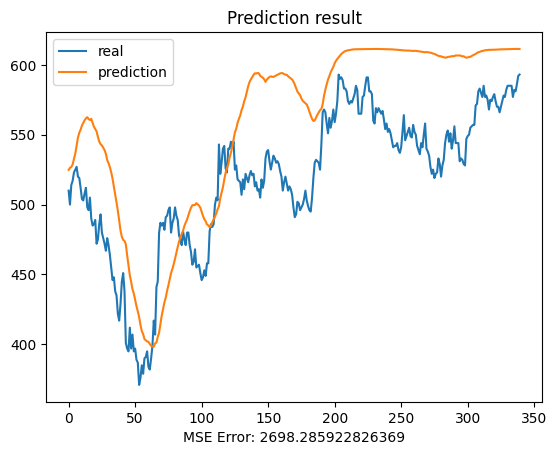

In [16]:
from sklearn.metrics import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


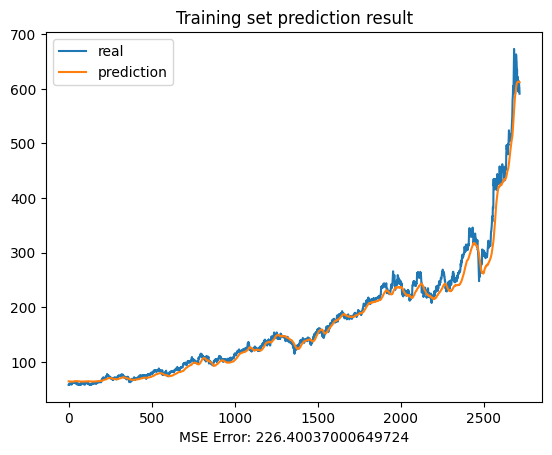

In [14]:
from sklearn.metrics import mean_squared_error  # test on training test
y_predict = model.predict(x_train)
y_real = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Training set prediction result')
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error  # test on training test
y_predict = model.predict(x_val)
y_real = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Validation set prediction result')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


ValueError: non-broadcastable output operand with shape (340,1) doesn't match the broadcast shape (340,4)